# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "Mask_RCNN-tf2/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class HandsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "Hands"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16

    MEAN_PIXEL = np.array([123.7, 116.8, 103.9, 103.9]) # for RGB-D
    IMAGE_CHANNEL_COUNT = 4 


    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256 
    IMAGE_MAX_DIM = 320
    
    USE_MINI_MASK = True
    MINI_MASK_SHAPE = (64, 80)
    MASK_SHAPE = [28, 28] # SHOULD BE CHANGED also somewhere else
    IMAGE_RESIZE_MODE = "deform" # CUSTOM
    
    #BACKBONE = "resnet50"

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    TRAIN_ROIS_PER_IMAGE = 10

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = HandsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            4
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              deform
IMAGE_SHAPE                    [256 320   4]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [19]:
import skimage.io
class HandsDataset(utils.Dataset):

    # overriden for RGB-D
    def load_image(self, image_id):
        image = skimage.io.imread(self.image_info[image_id]['path'])
        if image.ndim == 2:
            #image = skimage.color.gray2rgb(image)
            image = np.stack((image,)*4, axis=-1)
        return image

    def load_dataset(self, dataset_dir, subset_suffix):
        # Add classes. We have one class.
        # Naming the dataset nucleus, and the class nucleus
        self.add_class("hand", 1, "hand")

        dataset_dir = os.path.join(dataset_dir, "img"+subset_suffix)
        image_ids = list(os.walk(dataset_dir))[0][2]

        # Add images
        for image_id in image_ids:
            self.add_image(
                "hand",
                image_id=image_id,
                path=os.path.join(dataset_dir, image_id),
                subset = subset_suffix)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        info = self.image_info[image_id]
        # Get mask directory from image path
        mask_dir = os.path.join(os.path.dirname(os.path.dirname(info['path'])), "mask-arm"+info['subset'])

        # Read mask files from .png image
        mask = []
        mask = skimage.io.imread(os.path.join(mask_dir, info['id'])).astype(np.bool)
        mask = mask[..., np.newaxis]
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID, we return an array of ones
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "hand":
            return info["id"]
        else:
            super(self.__class__, self).image_reference(image_id)
            
DATASET_DIR = os.path.join(ROOT_DIR, "dataset")

# Training dataset
dataset_train = HandsDataset()
dataset_train.load_dataset(DATASET_DIR,"")
dataset_train.prepare()

# Validation dataset
dataset_val = HandsDataset()
dataset_val.load_dataset(DATASET_DIR,"-valid")
dataset_val.prepare()

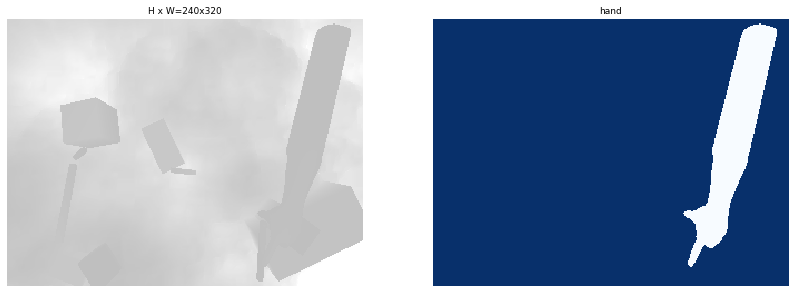

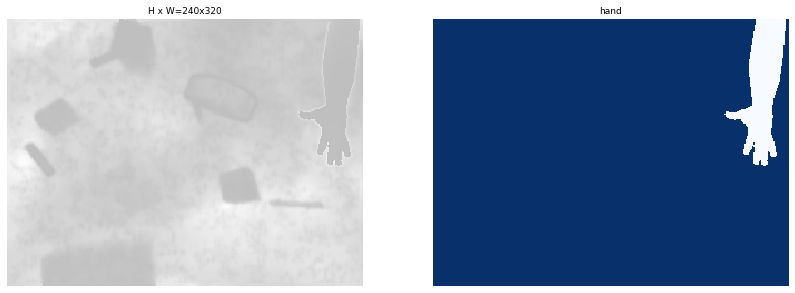

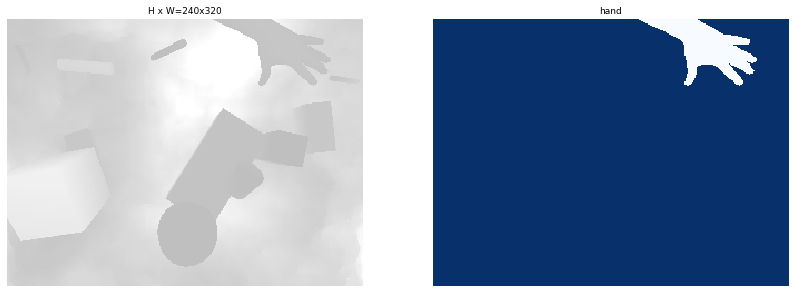

In [20]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit = 1)

## Create Model

In [21]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [22]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask", "conv1"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [23]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: c:\Users\Stefan\source\repos\HGR_CNN\logs\hands20220222T1335\mask_rcnn_hands_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_

C:\Users\Stefan\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Stefan\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=5, 
            layers="all")

a "Graph" tensor. It is possible to have Graph tensors
leak out of the function building context by including a
tf.init_scope in your function building code.
For example, the following function will fail:
  @tf.function
  def has_init_scope():
    my_constant = tf.constant(1.)
    with tf.init_scope():
      added = my_constant * 2
The graph tensor has name: anchors_1/Variable:0
Epoch 3/5


C:\Users\Stefan\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Stefan\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\Stefan\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


100/100 [==============================] - 707s 7s/step - loss: 0.7186 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.2033 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0498 - mrcnn_mask_loss: 0.0849 - val_loss: 0.5236 - val_rpn_class_loss: 0.0026 - val_rpn_bbox_loss: 0.1240 - val_mrcnn_class_loss: 0.0144 - val_mrcnn_bbox_loss: 0.0525 - val_mrcnn_mask_loss: 0.0683
Epoch 4/5
100/100 [==============================] - 216s 2s/step - loss: 0.5405 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1257 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.0838 - val_loss: 0.4046 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.1050 - val_mrcnn_class_loss: 0.0070 - val_mrcnn_bbox_loss: 0.0255 - val_mrcnn_mask_loss: 0.0605
Epoch 5/5
100/100 [==============================] - 210s 2s/step - loss: 0.5187 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.0804 - val_loss: 0.4342 - val_rpn_class_loss: 0.0031 -

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(HandsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  c:\Users\Stefan\source\repos\HGR_CNN\logs\hands20220222T1050\mask_rcnn_hands_0005.h5
Re-starting from epoch 5


original_image           shape: (256, 320, 3)         min:    0.00000  max:  174.00000  float64
image_meta               shape: (14,)                 min:    0.00000  max: 23299.00000  int32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  122.00000  max:  320.00000  int32
gt_mask                  shape: (256, 320, 1)         min:    0.00000  max:    1.00000  float64


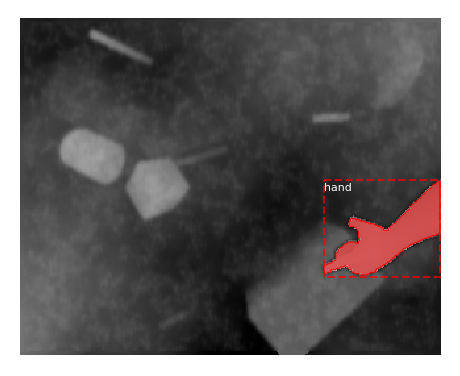

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 320, 3)         min:    0.00000  max:  174.00000  float64
molded_images            shape: (1, 256, 320, 3)      min: -123.70000  max:   70.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int32
anchors                  shape: (1, 20460, 4)         min:   -0.35494  max:    1.10396  float32


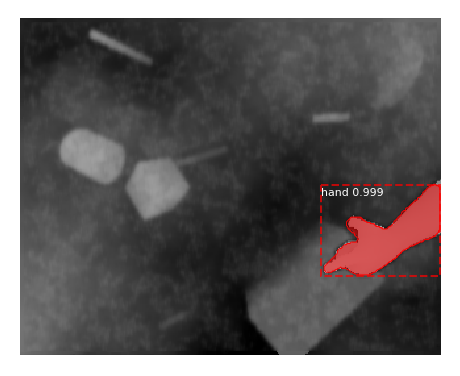

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

Test on real image

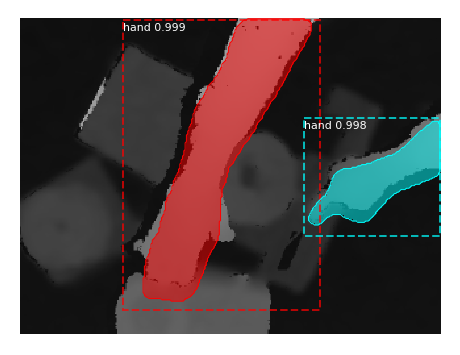

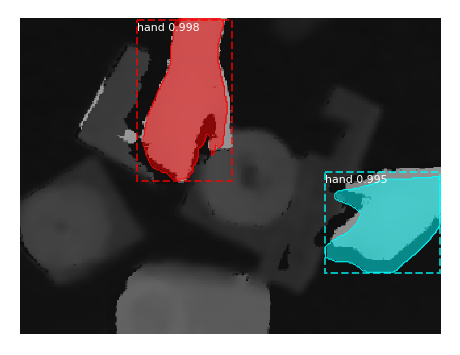

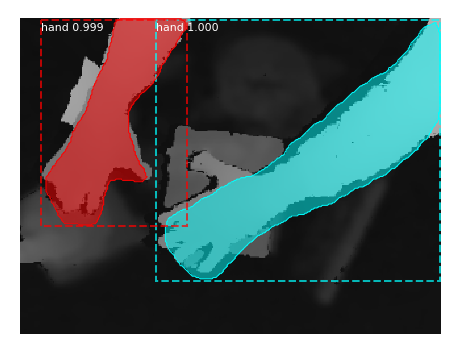

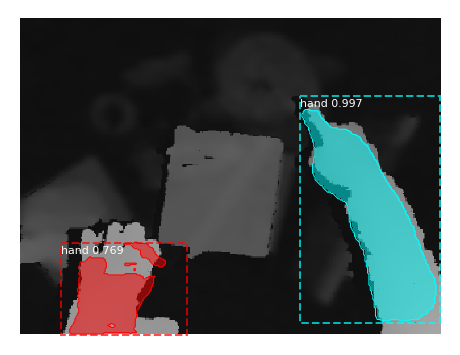

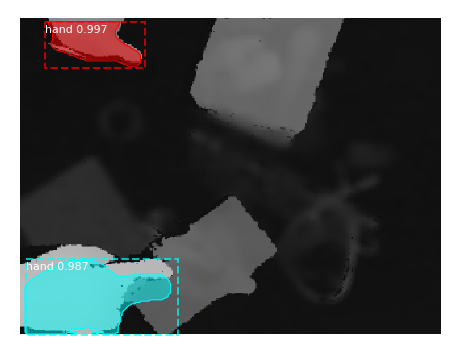

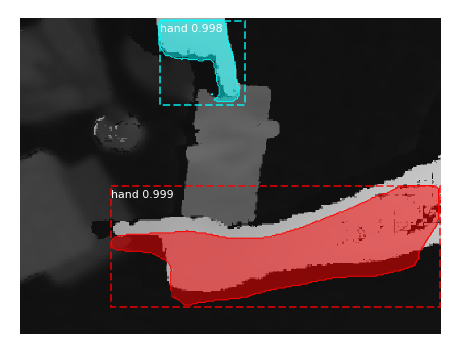

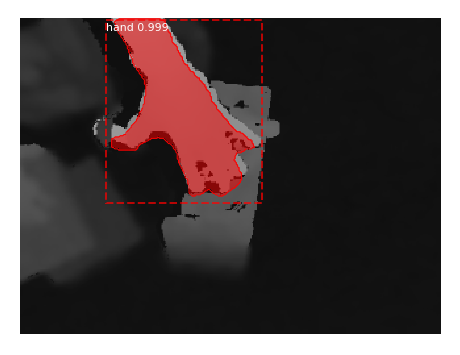

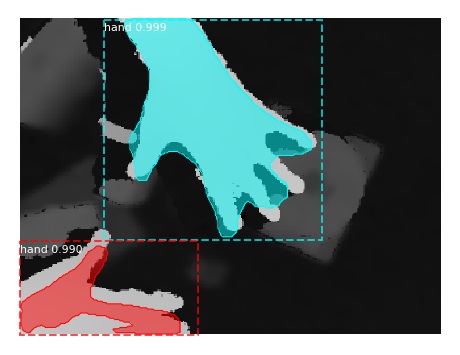

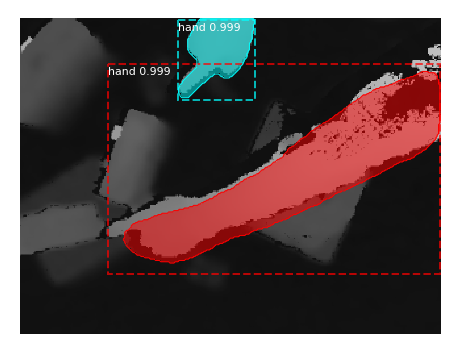

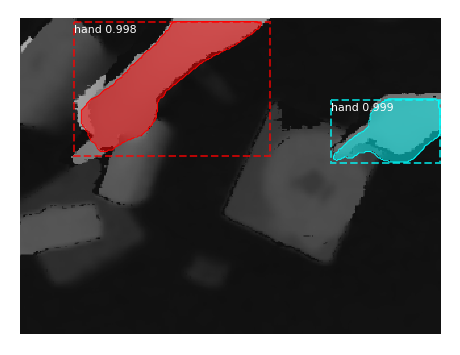

In [ ]:
def test_real_image(image_name):
    original_image = skimage.io.imread(os.path.join(DATASET_DIR, "real_cam", "2_ruce_rukavice_250", "Depth", image_name))
    if image.ndim == 2:
        #image = skimage.color.gray2rgb(image)
        image = np.stack((image,)*4, axis=-1)
            
    r = model.detect([original_image], verbose=0)[0]
    
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                        dataset_val.class_names, r['scores'], ax=get_ax())
    
test_real_image("342.png")
test_real_image("341.png")
test_real_image("355.png")
test_real_image("374.png")
test_real_image("417.png")
test_real_image("452.png")
test_real_image("488.png")
test_real_image("503.png")
test_real_image("517.png")
test_real_image("525.png")

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  1.0
